#### Assumptions
* Prijzen worden ingeschat op een bepaald jaar, vanaf dat jaar worden prijzen geescaleerd naar de toekomst. 
* price_reference_year (dan NPV 1 en de escalation is 1)
* price_reference_year + 1 CAPEX start
* CAPEX are distributed via the allocation factors, allocation starts immediately in startyear
* CAPEX is escalated with escalation factors
* escalation values start on the start year (if startyear is 2023, then the CAPEX values are 1.02 * Capex values)
* OPEX values are the sum of the escalated CAPEX values, and OPEX values are themselves not escalated
* all things have decommissioning costs
* some things may have residual value
* automatisch herinvesteren (misschien een flag toevoegen of reinvestment met behoud van revenue kan)

#### Potential to do's
* add geographical data to the system objects (to plot them in space, but also to possibly calculate distances)
* add 'owner' per system object (is the business case for each stakeholder positive?)
* now in case of an error, a default value is returned. The exeptions should return a clear error statement
* develop tests
* check what are now input fields and what is read from the xls (make sure this is handeled properly

#### 0. Import basic methods from source.py
Import useful methods from source.py (NB: can later be integrated into a package)

In [1]:
from source2 import *
# from source import *

In [2]:
mapping = load_input_from_xls(filename=r'H2 Model - Input sheet.xlsm')
Inputs = extract_scenario(mapping, 'Scenario1')

##### generate objects

In [9]:
turbine_data = get_object_data(Inputs=Inputs, 
                               subsystem='Wind energy source & Transport', 
                               element='Offshore wind park',
                               component='Turbine')
foundation_data = get_object_data(Inputs=Inputs, 
                               subsystem='Wind energy source & Transport', 
                               element='Offshore wind park',
                               component='Foundation & cable')


issue detected
issue detected


In [10]:
lifecycle = 25
Turbine = Object(**turbine_data)
Foundation = Object(**foundation_data)

##### generate cashflows

In [11]:
Turbine.generate_cashflows(startyear=2025, lifecycle=lifecycle, Debug=False)
Foundation.generate_cashflows(startyear=2023, lifecycle=lifecycle, Debug=False)

##### combine cashflows and add revenues

In [12]:
df_combined=combine_cashflow_dataframes([Foundation.df, Turbine.df])
df_combined.revenue = 0.1 * 371_017_886 * 1000/50
for i in range(3):
    df_combined.loc[2023+i, 'revenue'] = 0

##### calculate NPVs

In [13]:
df_combined_npv=calculate_npv(df_combined, 2023, WACC=0.0984)

##### plot

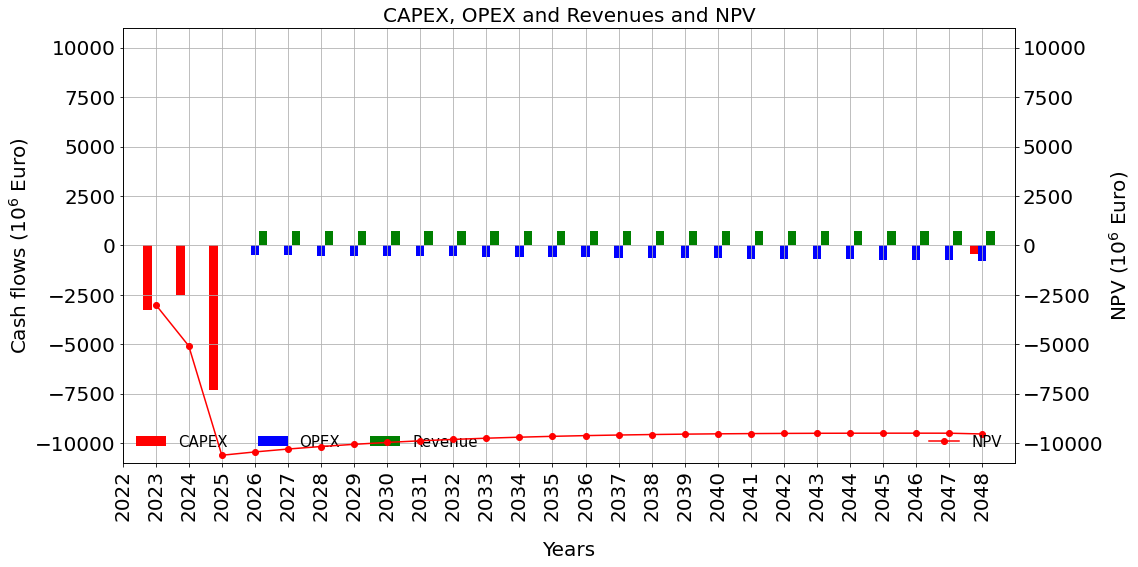

In [14]:
create_npv_plot(df_combined_npv)

Total windpark capacity * operational hours = Wind Energy Production per Year
3000 MW * 4380 h = 13.140.000 MWh 

Operational years * Production per year = Wind Energy Total Production
30 * 13.140.000 = 394.200.000 MWh 

Inter-array cable transport loss = 2%
Wind Energy to AC substation = (100 - 2%) * Wind Energy Total Production = 386.316.000 MWh 

DC collection cable Transformation loss = 2%
AC Substation energy to HVDC Converter = (100 - 2%) * Wind Energy to AC Substation = 378.589.680 MWh 

HVDC Cable Conversion loss = 2%
HVDC Converter energy to Electrolyser/DCAC Converter = (100 - 2%) * AC Substation energy to HVDC Converter = 371.017.886 MWh 

Hydrogen production 
Percentage hydrogen of total production = 100%
HVDC Converter energy to Electrolyser = HVDC Converter energy to Electrolyser/DCAC Converter * Percentage hydrogen of total production = 371.017.886 MWh 

Electrolyser Conversion MWh to tons Hydrogen = 50 MWh / tons
Electrolyser Hydrogen Production = 371.017.886 MWh * 50 = 7.420.358 tons H2 

In case of offshore hydrogen production:
H2 Pipeline transport loss = 2%
Hydrogen onshore = (100 - 2%) * Electrolyser Hydrogen Production = 7.271.951 tons H2 

Total hydrogen revenue
Hydrogen market price = 2 EUR / kg
Annual revenue = Annual production * Hydrogen Market price * Escalation factor
Total revenue = Sum of annual revenues

#### 1. Open xls file and ingest Inputs table
Note I am assuming that all inputs will be aggregated into one single inputs table

In [12]:

Inputs.head()

,Category,Sub-system,Element,Component,Description,Number,Unit,Comments
0,System input,Wind energy source & Transport,Offshore wind park,-,Total Windpark Capacity,3000,MW,None
1,System input,Wind energy source & Transport,Offshore wind park,Turbine,Windturbine Capacity per unit,20,MW,None
2,System input,Wind energy source & Transport,Offshore wind park,Inter-array cable,Length,50,km,None
3,System input,AC Substation & Transport,AC Substation & Transport,AC Substation,Capacity per unit,2000,MW,None
4,System input,AC Substation & Transport,AC Substation & Transport,AC collection cable,Length,25,km,None


#### 2. Data inspection 

In [13]:
Inputs.columns

Index(['Category', 'Sub-system', 'Element', 'Component', 'Description',
       'Number', 'Unit', 'Comments'],
      dtype='object')

In [14]:
Inputs[Inputs['Sub-system']=='Wind energy source & Transport'].head()

,Category,Sub-system,Element,Component,Description,Number,Unit,Comments
0,System input,Wind energy source & Transport,Offshore wind park,-,Total Windpark Capacity,3000,MW,None
1,System input,Wind energy source & Transport,Offshore wind park,Turbine,Windturbine Capacity per unit,20,MW,None
2,System input,Wind energy source & Transport,Offshore wind park,Inter-array cable,Length,50,km,None
14,System input,Wind energy source & Transport,Offshore wind park,Inter-array cable,Transport loss,0.02,%,None
23,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Development and Proj...,207000,EUR / MW,"0,1 * Foundation procurement"


In [15]:
list(Inputs['Sub-system'].unique())

['Wind energy source & Transport',
 'AC Substation & Transport',
 'Converter & Transport',
 'Electrolysis, Electricity & Transport',
 '-']

In [16]:
list(Inputs['Element'].unique())

['Offshore wind park',
 'AC Substation & Transport',
 'Converter',
 'Electrolysis',
 'Electricity',
 'Facility location',
 'Transport',
 '-']

In [17]:
list(Inputs['Component'].unique())

['-',
 'Turbine',
 'Inter-array cable',
 'AC Substation',
 'AC collection cable',
 'HVDC Converter',
 'HVDC cable',
 'Electrolyser',
 'DCAC Converter',
 'Artificial island',
 'Mainland',
 'H2 Pipeline',
 'Electricity cable',
 'HVDC Cable',
 'Foundation & cable',
 'DC collection cable',
 'Desalination unit',
 'Compressor unit',
 'Storage unit',
 'Compressor after storage']

In [18]:
subsystem='Wind energy source & Transport'
element='Offshore wind park'
component='Foundation & cable'

Inputs[
    (Inputs['Sub-system'] == subsystem) &
    (Inputs['Element'] == element) &
    (Inputs['Component'] == component) 
]

,Category,Sub-system,Element,Component,Description,Number,Unit,Comments
23,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Development and Proj...,207000,EUR / MW,"0,1 * Foundation procurement"
24,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Procurement),2070000,EUR / MW,"1,8 * Turbine procurement"
25,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Foundation & cable costs (Installation and Com...,414000,EUR / MW,"0,2 * Foundation procurement"
26,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Number of units,3000,MW,Unit = MW
27,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Construction duration,3,years,None
28,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Share of Investments in Year 1,0.4,% of Capex total,None
29,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Share of Investments in Year 2,0.3,% of Capex total,None
30,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Share of Investments in Year 3,0.3,% of Capex total,None
31,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Economic Lifetime,50,years,None
32,Capex,Wind energy source & Transport,Offshore wind park,Foundation & cable,Depreciation Flag,1,flag,None


#### 3. Select one item from the Inputs table (generate cashflow overview)

##### A. do per item

In [19]:
%%time
df_Foundations = Inputs_2_cashflow(Inputs, 
                                   startyear=2023,
                                   lifecycle=40,
                                   subsystem='Wind energy source & Transport',
                                   element='Offshore wind park',
                                   component='Foundation & cable',
                                   Debug=True)

'Escalation base year Foundation & cable: 2023'

'Escalation rate Foundation & cable: 0.02'

'Number of units Foundation & cable: 3000 MW'

'Construction duration Foundation & cable: 3 years'

'Construction allocation Foundation & cable: [0.4, 0.3, 0.3] per year'

'Economic Lifetime Foundation & cable: 50 years'

'Depreciation Flag Foundation & cable: 1'

'Yearly Variable Costs Flag Foundation & cable: 1'

'Yearly Variable Costs Rate Foundation & cable: 0.03'

'Insurance Flag Foundation & cable: 1'

'Insurance Rate Foundation & cable: 0.005'

'Decommissioning Foundation & cable: 0.02'

'Residual Value Foundation & cable: 0.01'

'Escalation years: [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063]'

'Escalation values: [1.02, 1.0404, 1.061208, 1.08243216, 1.1040808032, 1.126162419264, 1.14868566764928, 1.1716593810022657, 1.195092568622311, 1.2189944199947573, 1.2433743083946525, 1.2682417945625455, 1.2936066304537963, 1.3194787630628724, 1.3458683383241299, 1.3727857050906125, 1.4002414191924248, 1.4282462475762734, 1.4568111725277988, 1.485947395978355, 1.515666343897922, 1.5459796707758806, 1.5768992641913981, 1.6084372494752261, 1.6406059944647307, 1.6734181143540252, 1.7068864766411058, 1.741024206173928, 1.7758446902974065, 1.8113615841033548, 1.847588815785422, 1.8845405921011305, 1.9222314039431532, 1.9606760320220162, 1.9998895526624565, 2.0398873437157055, 2.08068509059002, 2.1222987924018204, 2.164744768249857, 2.208039663614854, 2.252200456887151]'

'CAPEX total Foundation & cable: 2691000 eu per MW'

'CAPEX years: [2023, 2024, 2025]'

'CAPEX values: [-3229200000.0, -2421900000.0, -2421900000.0]'

decommmissioning in 2063
Residual value 1614600000.0


'CAPEX years escalated: [2023, 2024, 2025, 2063]'

'CAPEX values escalated: [-3293784000.0, -2519744760.0, -2570139655.2, -363640285.7689994]'

'OPEX value: -306155804.533915'

'OPEX years escalated: [2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063]'

'OPEX values escalated: [-331392888.7981834, -338020746.57414705, -344781161.50563, -351676784.7357426, -358710320.4304575, -365884526.8390666, -373202217.375848, -380666261.72336495, -388279586.9578322, -396045178.6969889, -403966082.2709287, -412045403.91634727, -420286311.9946742, -428692038.23456776, -437265878.9992591, -446011196.57924426, -454931420.5108292, -464030048.9210458, -473310649.89946675, -482776862.89745605, -492432400.15540516, -502281048.1585133, -512326669.12168354, -522573202.50411725, -533024666.55419964, -543685159.8852836, -554558863.0829893, -565650040.3446491, -576963041.1515421, -588502301.974573, -600272348.0140644, -612277794.9743457, -624523350.8738326, -637013817.8913093, -649754094.2491355, -662749176.1341183, -676004159.6568006, -689524242.8499366]'

CPU times: total: 219 ms
Wall time: 219 ms


In [20]:
%%time
df_npv_Foundations = calculate_npv(df_Foundations,
#                                 baseyear=Inputs[Inputs.Description == 'Escalation base year'].Number.item(),
                                baseyear=2023,
                                WACC=Inputs[Inputs.Description == 'WACC'].Number.item())

CPU times: total: 31.2 ms
Wall time: 28.6 ms


CPU times: total: 8.16 s
Wall time: 9.69 s


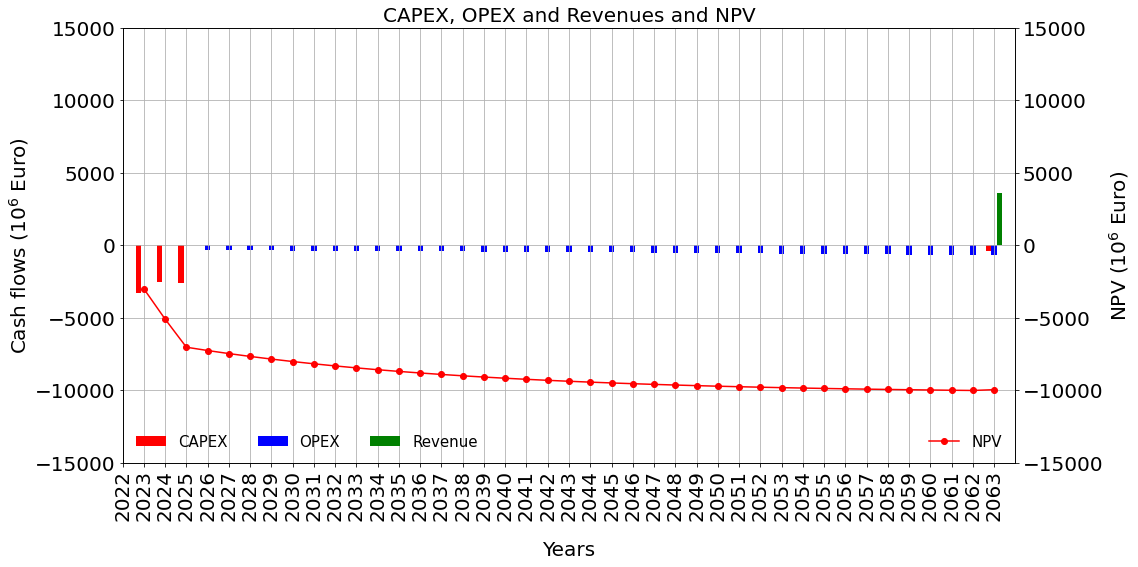

In [21]:
%%time
lims = [-15000, 15000]
create_npv_plot(df_npv_Foundations, cash_flow_lims=lims, npv_lims=lims)

In [23]:
%%time
df_Turbines = Inputs_2_cashflow(Inputs, 
                                   startyear=2025,
                                   lifecycle=50,
                                   subsystem='Wind energy source & Transport',
                                   element='Offshore wind park',
                                   component='Turbine',
                                   Debug=False)

reinvest in 2050
decommmissioning in 2073
Residual value 358800000.0
CPU times: total: 93.8 ms
Wall time: 105 ms


In [24]:
%%time
df_npv_Turbines = calculate_npv(df_Turbines,
                                baseyear=2025,
                                WACC=Inputs[Inputs.Description == 'WACC'].Number.item())

CPU times: total: 31.2 ms
Wall time: 44.2 ms


CPU times: total: 8.83 s
Wall time: 9.3 s


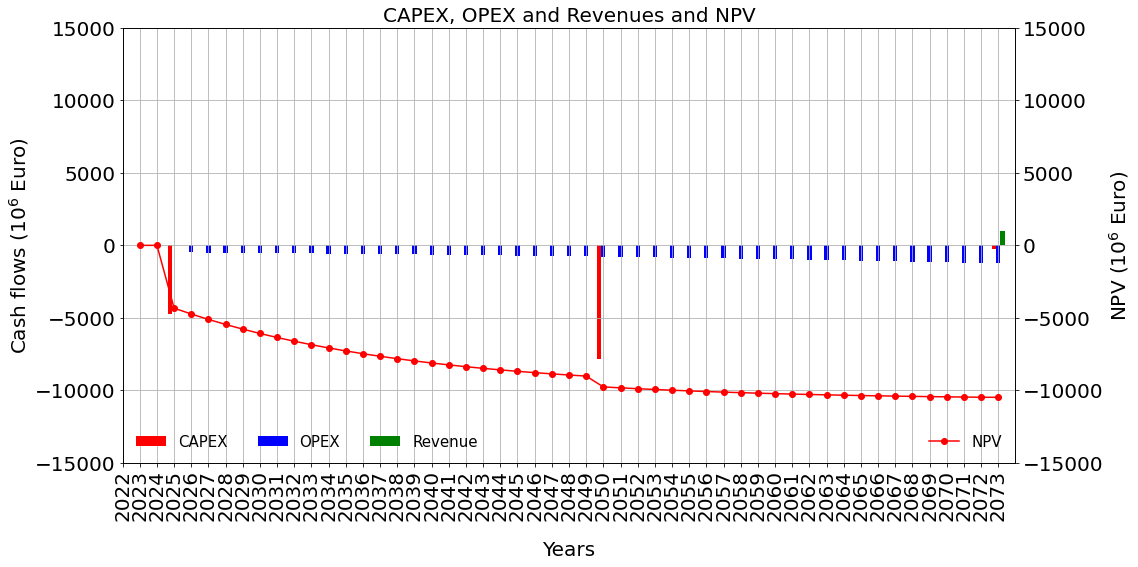

In [25]:
%%time
lims = [-15000, 15000]
create_npv_plot(df_npv_Turbines, cash_flow_lims=lims, npv_lims=lims)

##### B. combine two items

In [26]:
df_Foundations = Inputs_2_cashflow(Inputs, 
                                   startyear=2023,
                                   lifecycle=50,
                                   subsystem='Wind energy source & Transport',
                                   element='Offshore wind park',
                                   component='Foundation & cable',
                                   Debug=False)
df_Turbines = Inputs_2_cashflow(Inputs,
                                startyear=2025,
                                lifecycle=50,
                                subsystem='Wind energy source & Transport',
                                element='Offshore wind park',
                                component='Turbine',
                                Debug=False)
df_combined = combine_cashflow_dataframes([df_Foundations, df_Turbines])

decommmissioning in 2073
Residual value 0.0
reinvest in 2050
decommmissioning in 2073
Residual value 358800000.0


In [27]:
df_npv_combined = calculate_npv(df_combined)

CPU times: total: 8.67 s
Wall time: 9.86 s


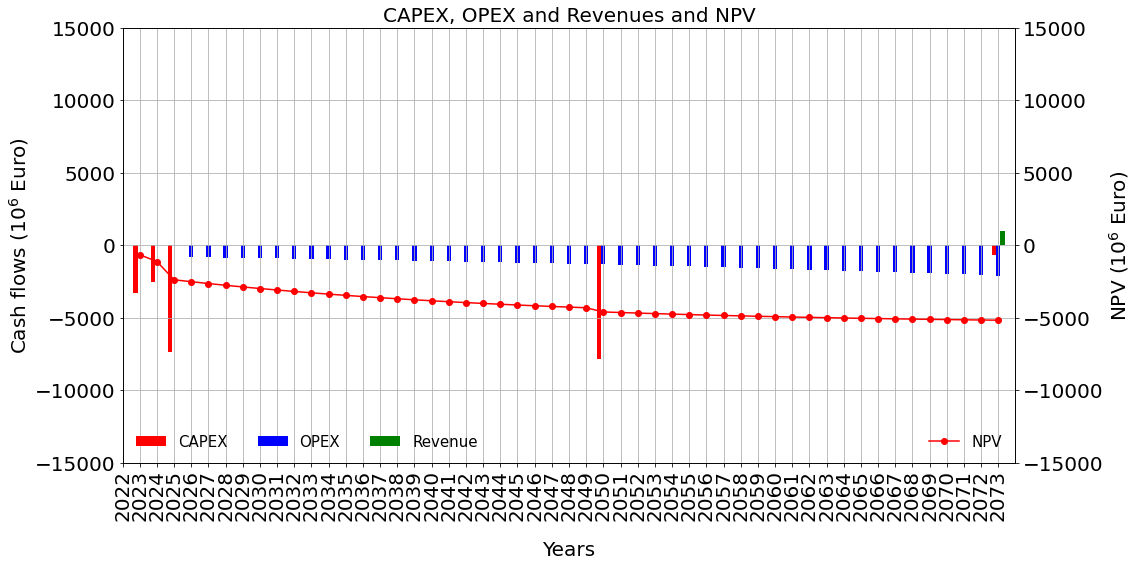

In [28]:
%%time
lims = [-15000, 15000]
create_npv_plot(df_npv_combined, cash_flow_lims=lims, npv_lims=lims)

# 